In [ ]:
# default_exp train_utils_fastai2

# train_utils_fastai2

> Basic utils for experiments - create databanch, learner with fastai v1.

In [ ]:
#hide
# from nbdev.showdoc import *

# imports

In [ ]:
#export
from fastai2.vision.all import *
from model_constructor.net import *
from fastscript.core import Param

In [ ]:
xresnet50

functools.partial(<class 'model_constructor.net.Net'>, expansion=4, layers=[3, 4, 6, 3], name='xresnet50')

In [ ]:
#export
# import math
# import torch
# from torch.optim.optimizer import Optimizer, required
# import itertools as it

# Dls

In [ ]:
#export
def get_dls(size=128, woof=1, bs=64, sh=0., workers=None):
#     if size<=224: path = URLs.IMAGEWOOF_320 if woof else URLs.IMAGENETTE_320
    if size<=224: path = URLs.IMAGEWOOF if woof else URLs.IMAGENETTE_320
    else        : path = URLs.IMAGEWOOF     if woof else URLs.IMAGENETTE
    source = untar_data(path)
    if workers is None: workers = min(8, num_cpus())
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    if sh: batch_tfms.append(RandomErasing(p=0.3, max_count=3, sh=sh))
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files, get_y=parent_label,
                       item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)],
                       batch_tfms=batch_tfms)
    return dblock.dataloaders(source, path=source, bs=bs, num_workers=workers)


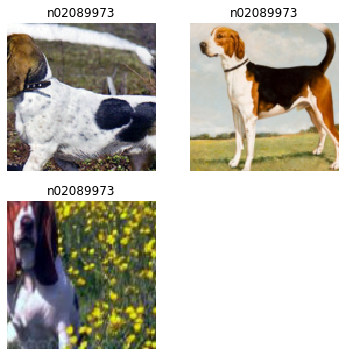

In [ ]:
# 
dls = get_dls()
dls.show_batch(max_n=3)

In [ ]:
# # 
# def get_data(size=128, woof=1, bs=64, workers=None, **kwargs):
#     if woof:
#         path = URLs.IMAGEWOOF    # if woof 
#     else:
#         path = URLs.IMAGENETTE
#     path = untar_data(path)
#     print('data path  ', path)
#     n_gpus = num_distrib() or 1
#     if workers is None: workers = min(8, num_cpus()//n_gpus)
#     return (ImageList.from_folder(path).split_by_folder(valid='val')
#             .label_from_folder().transform(([flip_lr(p=0.5)], []), size=size)
#             .databunch(bs=bs, num_workers=workers)
#             .presize(size, scale=(0.35,1))
#             .normalize(imagenet_stats))

# Learner

In [ ]:
# def get_learn(
#         gpu:Param("GPU to run on", str)=None,
#         woof: Param("Use imagewoof (otherwise imagenette)", int)=1,
#         size: Param("Size (px: 128,192,224)", int)=128,
#         alpha: Param("Alpha", float)=0.99, 
#         mom: Param("Momentum", float)=0.95, #? 0.9
#         eps: Param("epsilon", float)=1e-6,
#         bs: Param("Batch size", int)=64,
#         mixup: Param("Mixup", float)=0.,
#         opt: Param("Optimizer (adam,rms,sgd)", str)='ranger',
#         sa: Param("Self-attention", int)=0,
#         sym: Param("Symmetry for self-attention", int)=0,
#         model: Param('model as partial', callable) = xresnet50
#         ):
 
#     if   opt=='adam' : opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)
#     elif opt=='ranger'  : opt_func = partial(Ranger,  betas=(mom,alpha), eps=eps)
#     data = get_data(size, woof, bs)
#     learn = (Learner(data, model(), wd=1e-2, opt_func=opt_func,
#              metrics=[accuracy,top_k_accuracy],
#              bn_wd=False, true_wd=True,
#              loss_func = LabelSmoothingCrossEntropy(),))
#     print('Learn path', learn.path)
#     if mixup: learn = learn.mixup(alpha=mixup)
#     return learn

In [ ]:
# export
def get_learn(
    gpu:   Param("GPU to run on", int)=None,
    woof:  Param("Use imagewoof (otherwise imagenette)", int)=1,
#     lr:    Param("Learning rate", float)=1e-2,
    size:  Param("Size (px: 128,192,256)", int)=128,
    sqrmom:Param("sqr_mom", float)=0.99,
    mom:   Param("Momentum", float)=0.9,
    eps:   Param("epsilon", float)=1e-6,
    epochs:Param("Number of epochs", int)=5,
    bs:    Param("Batch size", int)=64,
    mixup: Param("Mixup", float)=0.,
    opt:   Param("Optimizer (adam,rms,sgd,ranger)", str)='ranger',
    model='xresnet50',
#     arch:  Param("Architecture", str)='xresnet50',
    sh:    Param("Random erase max proportion", float)=0.,
    sa:    Param("Self-attention", int)=0,
    sym:   Param("Symmetry for self-attention", int)=0,
    beta:  Param("SAdam softplus beta", float)=0.,
    act_fn:Param("Activation function", str)='Mish',
    fp16:  Param("Use mixed precision training", int)=0,
    pool:  Param("Pooling method", str)='AvgPool',
    dump:  Param("Print model; don't train", int)=0,
    runs:  Param("Number of times to repeat training", int)=1,
    meta:  Param("Metadata (ignored)", str)=''
):
    "Training of Imagenette."

    #gpu = setup_distrib(gpu)
    if gpu is not None: torch.cuda.set_device(gpu)
    if   opt=='adam'  : opt_func = partial(Adam, mom=mom, sqr_mom=sqrmom, eps=eps)
    elif opt=='rms'   : opt_func = partial(RMSprop, sqr_mom=sqrmom)
    elif opt=='sgd'   : opt_func = partial(SGD, mom=mom)
    elif opt=='ranger': opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

    dls = get_dls(size, woof, bs, sh=sh)
#     if not gpu: print(f'epochs: {epochs}; lr: {lr}; size: {size}; sqrmom: {sqrmom}; mom: {mom}; eps: {eps}')
    if model=='xresnet50':
        m,act_fn,pool = [globals()[o] for o in ('xresnet50',act_fn,pool)]
        model = m(c_out=10, act_cls=act_fn, sa=sa, sym=sym, pool=pool)
    else: model = model()
    learn = Learner(dls, model, opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
    if fp16: learn = learn.to_fp16()
#         cbs = MixUp(mixup) if mixup else []
    return learn


In [ ]:
model = xresnet50(c_out=10)

In [ ]:
model.act_fn = Mish()

In [ ]:
model()

Sequential(
  model xresnet50
  (stem): Sequential(
    (conv_0): ConvLayer(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (conv_1): ConvLayer(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (conv_2): ConvLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (stem_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (l_0): Sequential(
      (bl_0): ResBlock(
        (convs): Sequential(
          (conv_0): ConvLayer(
          

In [ ]:
learn = get_learn(model=model())

In [ ]:
#hide
learn

In [ ]:
epochs = 5
lr = 4e-3

In [ ]:
learn.fit_flat_cos(epochs, lr)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.160346,2.615049,0.238992,0.772461,00:40
1,1.930878,1.861334,0.392466,0.873505,00:37
2,1.814155,1.914208,0.406465,0.875032,00:37
3,1.678295,1.552787,0.538305,0.930517,00:37
4,1.444601,1.382842,0.617460,0.952660,00:38


In [ ]:
learn.model

Sequential(
  model xresnet50
  (stem): Sequential(
    (conv_0): ConvLayer(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (conv_1): ConvLayer(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (conv_2): ConvLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (stem_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (l_0): Sequential(
      (bl_0): ResBlock(
        (convs): Sequential(
          (conv_0): ConvLayer(
          

In [ ]:
model.sa = True

In [ ]:
learn = get_learn(model=model())

In [ ]:
learn.fit_flat_cos(epochs, lr)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.059624,2.469872,0.247137,0.723085,00:38
1,1.829601,1.709233,0.465513,0.887758,00:38
2,1.669240,2.182845,0.332146,0.843726,00:38
3,1.532140,1.461300,0.588699,0.937389,00:39
4,1.343642,1.289694,0.667091,0.959532,00:38
